In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
torch.cuda.is_available()

False

#data input

In [2]:
mean_gray= 0.1307
stddev_gray= 0.3081
#normalize the image with std and mean
#e.g: input[channel]=(input[channel]-mean[channel])/std(channel)
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean_gray,),(stddev_gray,))])

train_dataset=datasets.MNIST(root='./data', train=True, transform=transforms, download=True)
test_dataset=datasets.MNIST(root='./data', train=False, transform=transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#data exploration

label: 0


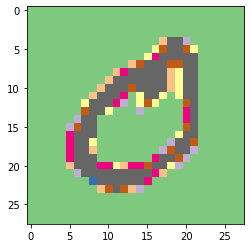

In [3]:
import matplotlib.pyplot as plt
label=train_dataset[21][1]
print('label:', label)
random_image = train_dataset[21][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28,28), cmap='Accent')

#data loaders

In [4]:
batch_size=100
epochs=10
train_load=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_load=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
print("Number of images in training set: {}".format(len(train_dataset)))
print("Number of images in test set: {}".format(len(test_dataset)))
print("Number of batches in the train loader: {}".format(len(train_load)))
print("Number of batches in the test loader: {}".format(len(test_load)))

Number of images in training set: 60000
Number of images in test set: 10000
Number of batches in the train loader: 600
Number of batches in the test loader: 100


#cnn model

In [6]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # Add layer 1  - CNN, BatchNorm, Relu, MaxPool
    self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
      
    # Add layer 2 - CNN, BatchNorm, Relu, MaxPool
    self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
    )
        
    # Add layer 3 - Linear, Dropout, Linear, Dropout
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.3)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.drop = nn.Dropout2d(0.3)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.drop(out)
    return out

#hyper parametrers

In [7]:
learning_rate = 0.001
loss_fn=nn.CrossEntropyLoss()
#loss_fn = nn.L1Loss()
momemtum = 0.9

model=CNN()
CUDA=torch.cuda.is_available()
if CUDA:
  model=model.cuda()

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momemtum)

#expected prediction

In [8]:
iteration=0
correct_nodata=0
correct_data=0
for i,(inputs,labels) in enumerate (train_load):
  if iteration==1:
    break
  inputs=Variable(inputs)
  labels=Variable(labels)
  if torch.cuda.is_available():
    inputs=inputs.cuda()
    labels=labels.cuda()

  print("For 1 iteration, this is what happens:")
  print("Input Shape:",inputs.shape)
  print("Labels Shape:", labels.shape)
  output = model(inputs)
  
  print("Output Shape:",output.shape)
  _,predicted_nodata=torch.max(output,1)
  
  print("Predicted Shape:",predicted_nodata.shape)
  print("Predicted Tensor:",predicted_nodata)
  correct_nodata +=(predicted_nodata==labels).sum()
  print("Correct Predictions:",correct_nodata)
  _,predicted_data = torch.max(output.data,1)
  correct_data +=(predicted_data==labels.data).sum()
  
  print("Correct Predictions:",correct_data)
  
  iteration+=1

For 1 iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Output Shape: torch.Size([100, 120])
Predicted Shape: torch.Size([100])
Predicted Tensor: tensor([ 86,   9,  28, 113,  71,  52,  51,  38,  86,  28,  24,  43,  93,  93,
         11,  86,  73,  27,  43,  51,  93,  58,  99,  37,  33,  12,  51,  27,
         80, 107,  21,  38,  43,  35,  37,  35,  12,  39,  55,  12,  73, 106,
         82,  33, 116, 105,  92,  12,  37,  28, 105,  73, 105,  24,  12, 113,
         37, 105,  45,   2,  73,  73,  11,  35,  52,  73, 105,  27,   9,  86,
        113,  27,  66,  28, 107,  93,  27,  24,  73,  28,  73,  80,  71,  43,
         92,  37, 116,  12,  92,  24,  68,  37,  27,  70,  27,  95,  73,   9,
         35,  11])
Correct Predictions: tensor(0)
Correct Predictions: tensor(0)


#train/test

In [9]:
num_epochs=20

train_loss=[]
test_loss=[]
train_accuracy=[]
test_accuracy=[]

# Training
for epoch in range(num_epochs):
  # Reset variables at 0 epoch
  correct=0
  iteration=0
  iter_loss=0.0
  
  model.train() # Training Mode
  
  for i,(inputs,labels) in enumerate(train_load):
    
    inputs=Variable(inputs)
    labels=Variable(labels)
    
    # if CUDA is avaible, shift to GPU (CUDA)
    CUDA=torch.cuda.is_available()
    if CUDA:
      inputs=inputs.cuda()
      labels=labels.cuda()
      
    optimizer.zero_grad() # clear gradient
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    iter_loss += loss.item() # Accumulate loss
    loss.backward() # backpropagation
    optimizer.step() # update weights
    
    # Save the correct predictions for training data
    _,predicted=torch.max(outputs,1)
    correct +=(predicted==labels).sum()
    iteration +=1
    
  train_loss.append(iter_loss/iteration)
  train_accuracy.append((100*correct/len(train_dataset)))
  
  # Testing
  correct=0
  iteration=0
  loss=0.0
  
  model.eval()  # Testing Mode
  
  for i, (inputs, labels) in enumerate(test_load):
    
    inputs=Variable(inputs)
    labels=Variable(labels)
    
    CUDA=torch.cuda.is_available()
    if CUDA:
      inputs=inputs.cuda()
      labels=labels.cuda()
    
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss += loss.item()
    
    _,predicted=torch.max(outputs,1)
    correct+=(predicted==labels).sum()
    
    iteration+=1
    
  test_loss.append(loss/iteration)
  test_accuracy.append((100*correct/len(test_dataset)))
  
  print('Epoch {}/{}, Training Loss:{:.3f}, Training Accuracy:{:.3f}, Testing Loss {:.3f}, Testing Accuracy:{:.3f}'
       .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))

Epoch 1/20, Training Loss:1.518, Training Accuracy:66.147, Testing Loss 0.003, Testing Accuracy:97.180
Epoch 2/20, Training Loss:1.231, Training Accuracy:72.513, Testing Loss 0.002, Testing Accuracy:97.960
Epoch 3/20, Training Loss:1.204, Training Accuracy:74.018, Testing Loss 0.001, Testing Accuracy:98.230
Epoch 4/20, Training Loss:1.198, Training Accuracy:74.665, Testing Loss 0.001, Testing Accuracy:98.430
Epoch 5/20, Training Loss:1.181, Training Accuracy:75.468, Testing Loss 0.001, Testing Accuracy:98.560
Epoch 6/20, Training Loss:1.154, Training Accuracy:76.155, Testing Loss 0.001, Testing Accuracy:98.640
Epoch 7/20, Training Loss:1.159, Training Accuracy:76.262, Testing Loss 0.001, Testing Accuracy:98.780
Epoch 8/20, Training Loss:1.148, Training Accuracy:76.675, Testing Loss 0.000, Testing Accuracy:98.700
Epoch 9/20, Training Loss:1.143, Training Accuracy:76.752, Testing Loss 0.001, Testing Accuracy:98.600
Epoch 10/20, Training Loss:1.140, Training Accuracy:76.998, Testing Loss 

#evaluation

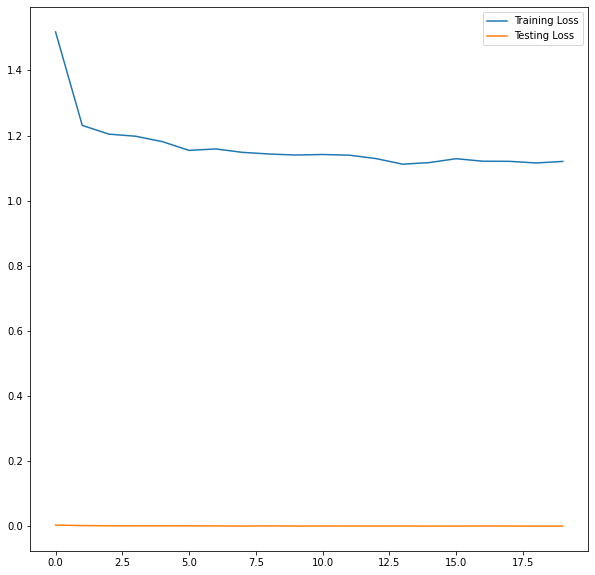

In [10]:
# Loss
f=plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

#accuracy

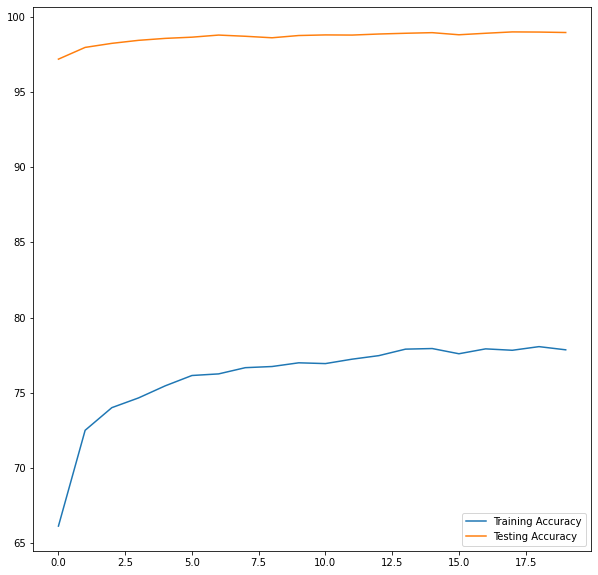

In [11]:
# Accuracy
f=plt.figure(figsize=(10,10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

#prediction

In [12]:
img= test_dataset[40][0].resize_((1,1,28,28))
img= Variable(img)
label= test_dataset[40][1]

model.eval()

if torch.cuda.is_available():
  model=model.cuda()
  img=img.cuda()
  
output=model(img)
print(output)
print(output.data)
_,predicted=torch.max(output,1)
print("Prediction is:",predicted.item())
print("Actual is:", label)

tensor([[-4.1856,  6.8537, -4.3341, -4.4672, -2.0447, -2.5556, -6.1744, -2.4187,
         -1.2644, -2.5810, -4.1525, -4.2048, -3.8834, -4.1639, -4.4010, -4.0217,
         -4.4004, -4.4757, -4.3101, -4.0819, -4.4885, -4.3720, -4.1018, -4.3284,
         -4.0098, -4.3211, -3.9736, -3.9564, -4.1772, -3.4527, -4.4091, -4.0022,
         -3.8906, -3.9353, -4.0369, -3.7924, -4.6578, -4.4074, -3.8560, -4.5212,
         -4.1168, -4.3782, -4.5778, -4.3923, -4.3894, -4.1759, -4.5436, -4.2570,
         -4.1188, -4.4592, -4.3037, -4.5029, -4.5510, -4.6508, -3.9209, -3.9961,
         -3.7748, -5.0310, -3.5308, -4.1354, -4.1940, -3.9937, -4.2604, -4.3975,
         -4.7282, -3.7845, -4.0394, -4.2991, -3.7041, -3.9042, -4.2317, -3.8864,
         -4.6427, -3.8060, -4.2560, -4.5499, -4.4302, -4.5123, -4.1775, -4.1937,
         -3.5148, -4.2097, -4.1435, -4.2312, -4.4721, -4.2636, -4.6341, -4.6985,
         -4.6298, -4.2169, -4.4510, -4.6865, -4.1784, -3.9601, -4.0327, -4.1997,
         -4.0751, -4.1893, -